In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import random

from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Set the paths for training and testing data
train_data_dir = 'Latest Dataset/Train'
test_data_dir = 'Latest Dataset/Test'
CATEGORIES = ["Anger", "Joy", "Natural", "Sadness"]
IMG_SIZE = 128

# Define image size and batch size
img_size = (128, 128)
batch_size = 16

In [2]:
# Initialize the Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [3]:
def detect_face(image_path, face_cascade):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        return None
    (x, y, w, h) = faces[0]  # Assuming one face per image
    face = gray[y:y+h, x:x+w]
    return cv2.resize(face, (128, 128))  # Resize to a fixed size

**Data Augmentation**

In [4]:
# Function to perform random rotation
def random_rotation(image):
    angle = random.uniform(-10, 10)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    return cv2.warpAffine(image, M, (w, h))

# Function to perform random horizontal flip
def random_flip(image):
    if random.random() > 0.5:
        return cv2.flip(image, 1)
    return image

# Function to change brightness
def random_brightness(image):
    factor = random.uniform(0.8, 1.2)
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

# Function to add gaussian blur
def random_blur(image):
    if random.random() > 0.5:
        ksize = random.choice([3, 5])
        return cv2.GaussianBlur(image, (ksize, ksize), 0)
    return image

# Function to apply all custom augmentations
def augment_image(image):
    image = random_rotation(image)
    image = random_flip(image)
    image = random_brightness(image)
    image = random_blur(image)
    return image

**Preprocess Dataset**

In [5]:
features = []
labels = []

for label, category in enumerate(CATEGORIES):
    class_dir = os.path.join(train_data_dir, category)
    if not os.path.isdir(class_dir):
        continue

    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        face = detect_face(image_path, face_cascade)
        
        if face is not None:
            augmented_face = augment_image(face)
            features.append(face.flatten())
            labels.append(label)
            features.append(augmented_face.flatten())
            labels.append(label)

features = np.array(features)
labels = np.array(labels)

In [6]:
# Normalize the data
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Feature Extraction - Principal Components Analysis (PCA)

**Computational Performance Metrics (Time)**

In [8]:
start_time = time.time()

# Apply PCA
n_components = 64  # Number of components you want to keep
pca = PCA(svd_solver='randomized', n_components=n_components, whiten=True)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

end_time = time.time()
execution_time = end_time - start_time
print(f'Feature extraction time: {execution_time} seconds')

Feature extraction time: 0.8665881156921387 seconds


In [9]:
# Transform the data
X_pca = pca.fit_transform(features)

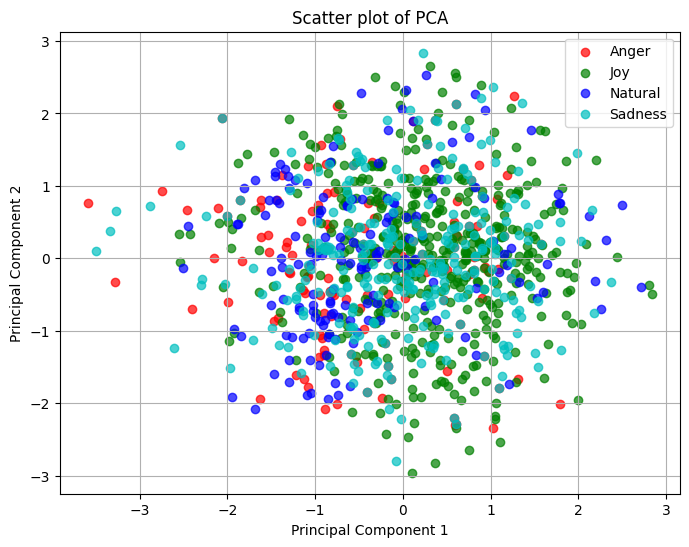

In [10]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i, color in zip(range(len(CATEGORIES)), colors):
    plt.scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], alpha=0.7, color=color, label=CATEGORIES[i])

plt.title('Scatter plot of PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.grid(True)
plt.show()

In [11]:
X_train_pca.shape

(833, 64)

## Fit to model

In [12]:
# One-hot encode labels
num_classes = len(CATEGORIES)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# Define the neural network architecture
input_shape = X_train_pca.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_shape,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train_pca, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test_pca, y_test_cat), shuffle=True, callbacks=[early_stopping, reduce_lr])

d:\FYP Face Recognition\virtual_env\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2358 - loss: 2.2670 - val_accuracy: 0.4115 - val_loss: 1.3791 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3075 - loss: 1.8796 - val_accuracy: 0.4258 - val_loss: 1.3573 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3482 - loss: 1.6591 - val_accuracy: 0.4545 - val_loss: 1.2977 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3639 - loss: 1.5711 - val_accuracy: 0.4833 - val_loss: 1.2608 - learning_rate: 0.0010
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4211 - loss: 1.3918 - val_accuracy: 0.4928 - val_loss: 1.2251 - learning_rate: 0.0010
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4423 - loss: 1.3492 - val_accuracy: 0.5024 - val_loss: 1.1922 - learning_rate: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4727 - loss: 1.3713 - val_accuracy:

**Proposed Model Graph**

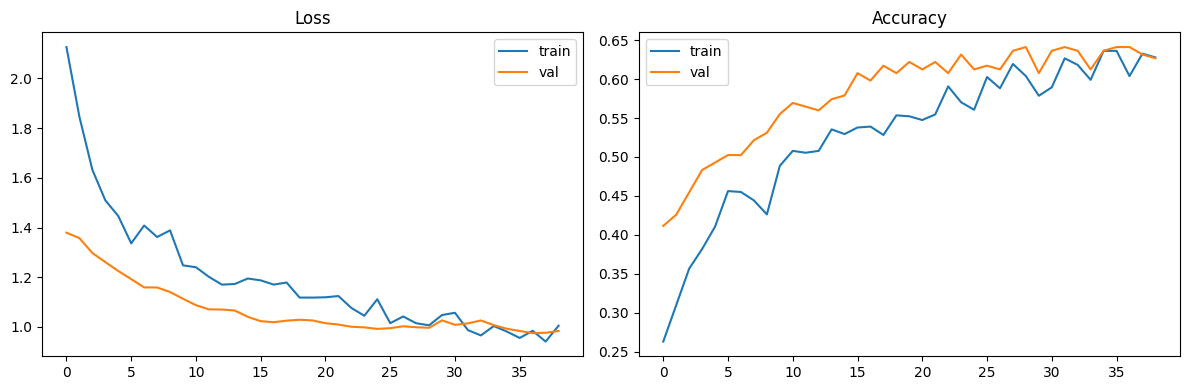

In [14]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

**Proposed Model Accuracy and Confusion Matrix**

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 64.11%
              precision    recall  f1-score   support

       Anger       0.67      0.06      0.11        33
         Joy       0.76      0.88      0.82        91
     Natural       0.45      0.48      0.47        29
     Sadness       0.54      0.68      0.60        56

    accuracy                           0.64       209
   macro avg       0.61      0.53      0.50       209
weighted avg       0.65      0.64      0.60       209



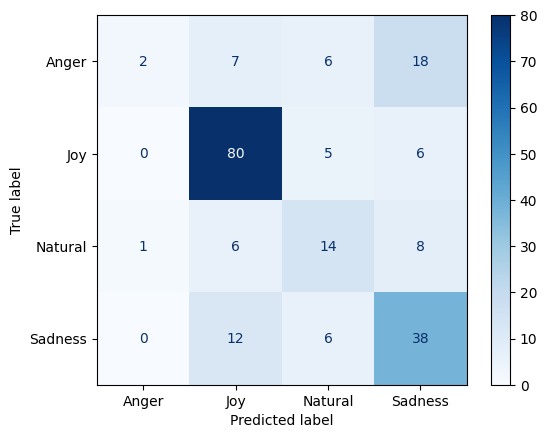

In [15]:
# Predict on the test set
y_pred_prob = model.predict(X_test_pca)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test_labels, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 57.89%
              precision    recall  f1-score   support

       Anger       0.22      0.15      0.18        33
         Joy       0.77      0.87      0.81        91
     Natural       0.40      0.41      0.41        29
     Sadness       0.47      0.45      0.46        56

    accuracy                           0.58       209
   macro avg       0.46      0.47      0.46       209
weighted avg       0.55      0.58      0.56       209



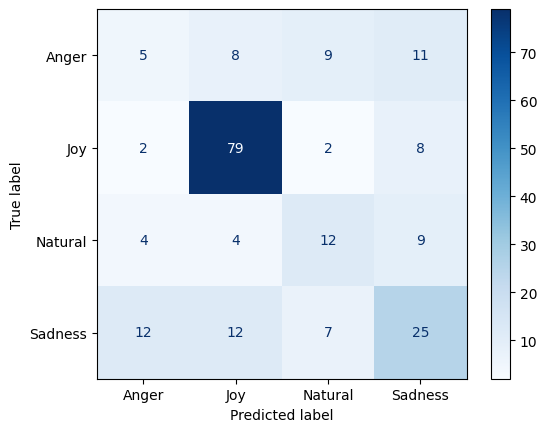

In [16]:
from sklearn.svm import SVC


svm = SVC(kernel='linear', random_state=42)
hist_svm = svm.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_prob = svm.predict(X_test_pca)
y_pred = y_pred_prob

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 60.77%
              precision    recall  f1-score   support

       Anger       0.22      0.15      0.18        33
         Joy       0.85      0.87      0.86        91
     Natural       0.43      0.41      0.42        29
     Sadness       0.48      0.55      0.51        56

    accuracy                           0.61       209
   macro avg       0.49      0.50      0.49       209
weighted avg       0.59      0.61      0.60       209



d:\FYP Face Recognition\virtual_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


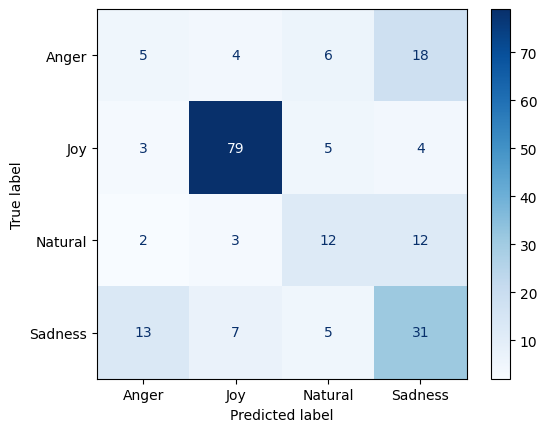

In [17]:
# Create a MLP classifier
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(activation='relu', solver='adam', shuffle=True)
hist = mlp.fit(X_train_pca, y_train)

# Predict on the test set
y_pred_prob = mlp.predict(X_test_pca)
y_pred = y_pred_prob
y_test_labels = y_test

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test_labels, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 47.85%
              precision    recall  f1-score   support

       Anger       0.24      0.27      0.25        33
         Joy       0.71      0.69      0.70        91
     Natural       0.26      0.24      0.25        29
     Sadness       0.38      0.38      0.38        56

    accuracy                           0.48       209
   macro avg       0.40      0.40      0.40       209
weighted avg       0.48      0.48      0.48       209



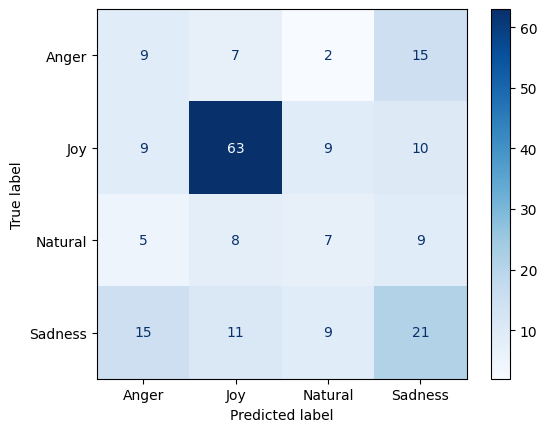

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=4, weights='uniform')
hist_knn = knn.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = knn.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 56.46%
              precision    recall  f1-score   support

       Anger       0.33      0.09      0.14        33
         Joy       0.66      0.93      0.77        91
     Natural       0.47      0.24      0.32        29
     Sadness       0.41      0.41      0.41        56

    accuracy                           0.56       209
   macro avg       0.47      0.42      0.41       209
weighted avg       0.51      0.56      0.51       209



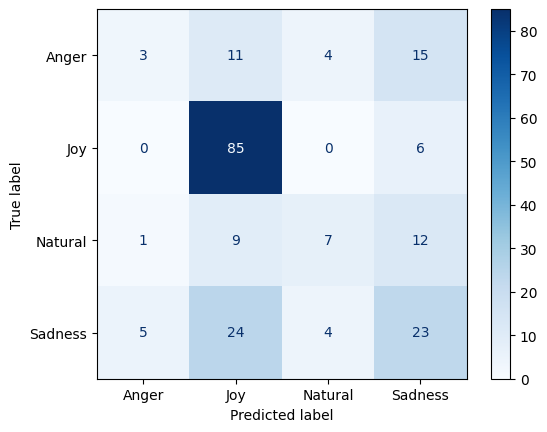

In [19]:
from sklearn.ensemble import RandomForestClassifier

randforest_clf = RandomForestClassifier()
hist_decision = randforest_clf.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = randforest_clf.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 43.54%
              precision    recall  f1-score   support

       Anger       0.09      0.09      0.09        33
         Joy       0.69      0.65      0.67        91
     Natural       0.25      0.21      0.23        29
     Sadness       0.34      0.41      0.37        56

    accuracy                           0.44       209
   macro avg       0.34      0.34      0.34       209
weighted avg       0.44      0.44      0.44       209



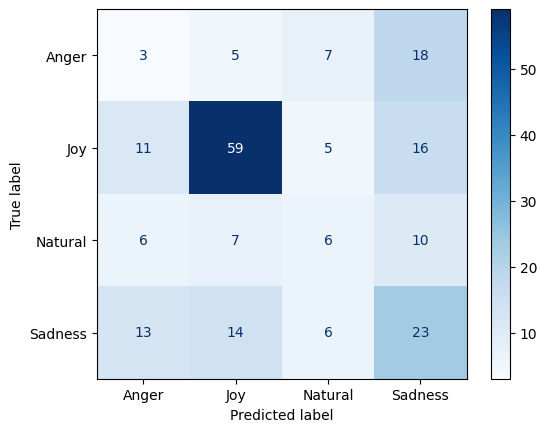

In [20]:
from sklearn.tree import DecisionTreeClassifier


decisiontree_clf = DecisionTreeClassifier()
hist_decision = decisiontree_clf.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = decisiontree_clf.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy: 57.89%
              precision    recall  f1-score   support

       Anger       0.25      0.06      0.10        33
         Joy       0.73      0.73      0.73        91
     Natural       0.47      0.48      0.47        29
     Sadness       0.48      0.70      0.57        56

    accuracy                           0.58       209
   macro avg       0.48      0.49      0.47       209
weighted avg       0.55      0.58      0.55       209



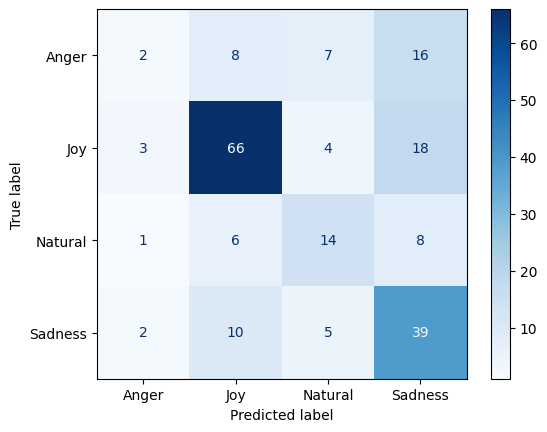

In [21]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
hist_ada = adaboost_clf.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = adaboost_clf.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Original Author's Model Architecture**

In [28]:
input_shape = X_train_pca.shape[1]

ori_model = tf.keras.models.Sequential()
ori_model.add(tf.keras.layers.InputLayer(input_shape=(input_shape,)))
ori_model.add(tf.keras.layers.Dense(units=50,
  activation='relu'))
ori_model.add(tf.keras.layers.Dense(units=150,
  activation='relu'))
ori_model.add(tf.keras.layers.Dense(units=300,
  activation='relu'))
ori_model.add(tf.keras.layers.Dense(units=200,
  activation='relu'))
ori_model.add(tf.keras.layers.Dense(units=70,
  activation='relu'))
ori_model.add(tf.keras.layers.Dense(units=4,
  activation='softmax'))
ori_model.compile(loss='categorical_crossentropy',
  optimizer='adam', metrics=['accuracy'])

ori_model.summary()

d:\FYP Face Recognition\virtual_env\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 150)            │         7,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 300)            │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 200)            │        60,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 70)             │        14,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │           284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,754 (510.76 KB)

 Trainable params: 130,754 (510.76 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
ori_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ori_hist = ori_model.fit(X_train_pca, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test_pca, y_test_cat), shuffle=True, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6983 - loss: 0.7709 - val_accuracy: 0.5837 - val_loss: 0.9898 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7563 - loss: 0.6072 - val_accuracy: 0.5263 - val_loss: 1.1390 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7771 - loss: 0.5641 - val_accuracy: 0.5933 - val_loss: 1.0079 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.3578 - val_accuracy: 0.5933 - val_loss: 1.1330 - learning_rate: 0.0010
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8781 - loss: 0.2915 - val_accuracy: 0.6029 - val_loss: 1.1656 - learning_rate: 0.0010
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9132 - loss: 0.2245 - val_accuracy: 0.5789 - val_loss: 1.3999 - learning_rate: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9384 - loss: 0.1719 - val_accuracy: 

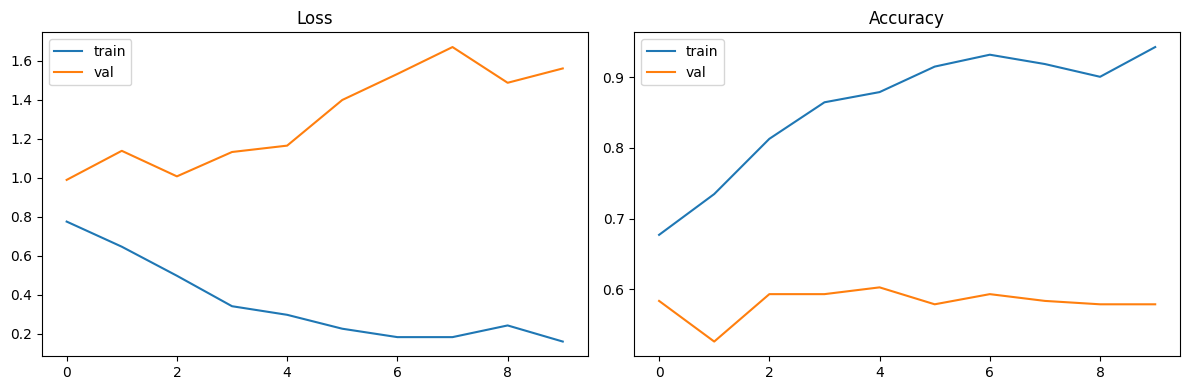

In [40]:
plot_learning_curves(ori_hist)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy: 58.37%
              precision    recall  f1-score   support

       Anger       0.33      0.03      0.06        33
         Joy       0.66      0.91      0.77        91
     Natural       0.43      0.31      0.36        29
     Sadness       0.48      0.52      0.50        56

    accuracy                           0.58       209
   macro avg       0.48      0.44      0.42       209
weighted avg       0.53      0.58      0.53       209



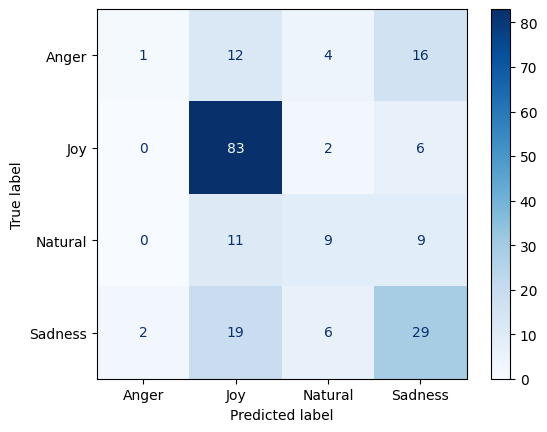

In [41]:
# Predict on the test set
y_pred_prob = ori_model.predict(X_test_pca)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_cat, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test_labels, y_pred, target_names=CATEGORIES))

# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.show()